# Import

In [ ]:
# https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [ ]:
import pandas as pd
from google.colab import drive
import torch
import numpy as np

!pip install nlpaug
import nlpaug.augmenter.word as naw

!pip install transformers
from transformers import BertTokenizer

import nltk
nltk.download('punkt')

from torch import nn
from transformers import BertModel

from torch.optim import Adam
from tqdm import tqdm

import matplotlib.pyplot as plt

drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preproccessing

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/nlp/data.csv')
df.head()

,Text,Classification,Sentiment
0,ریدم پس‌ِ کله‌ی خدائی که اینهمه وقت نخواسته سخ...,WithoutContent,None
1,در زدن خانم همسایه‌پایینی بود. تا گفتم سلام صو...,WithoutContent,None
2,فضای مجازی ویترینه . حریم خصوصی نیست. حوزه نما...,WithoutContent,None
3,بعد به مصرف‌کننده خونگی می‌گن کمتر حموم برو و ...,WithoutContent,None
4,این قراضه سنش دو برابر من بود، آه و واویلا دار...,WithoutContent,None


In [ ]:
df.describe()

,Text,Classification,Sentiment
count,4999,4999,4998
unique,4999,3,4
top,ریدم پس‌ِ کله‌ی خدائی که اینهمه وقت نخواسته سخ...,WithoutContent,None
freq,1,3832,3853


In [ ]:
df.isna().sum()

Text              0
Classification    0
Sentiment         1
dtype: int64

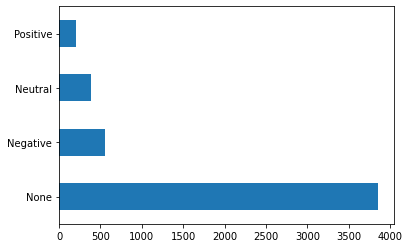

In [ ]:
df['Sentiment'].value_counts().plot(kind='barh')

In [ ]:
df['Sentiment'].value_counts()

None        3853
Negative     555
Neutral      385
Positive     205
Name: Sentiment, dtype: int64

In [ ]:
Positive = df[df['Sentiment'] == 'Positive']
Positive.shape

(205, 3)

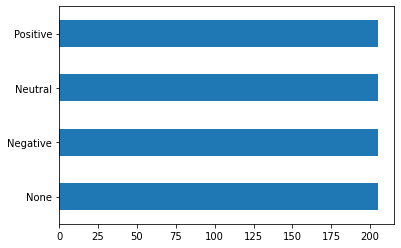

In [ ]:
data_Classification=pd.DataFrame()
data_Classification = data_Classification.append(df[df['Sentiment'] == 'None'].sample(Positive.shape[0]), ignore_index=True)
data_Classification = data_Classification.append(df[df['Sentiment'] == 'Negative'].sample(Positive.shape[0]), ignore_index=True)
data_Classification = data_Classification.append(df[df['Sentiment'] == 'Neutral'].sample(Positive.shape[0]), ignore_index=True)
data_Classification = data_Classification.append(df[df['Sentiment'] == 'Positive'].sample(Positive.shape[0]), ignore_index=True)

data_Classification['Sentiment'].value_counts().plot(kind='barh')

In [ ]:
def delete_Stopword(txt):
    file = nltk.word_tokenize(txt)
    newFile=''
    stopWord=[]
    fin=open('/content/drive/MyDrive/nlp/stopword.txt',encoding='utf8')

    for word in fin.readlines():
        stopWord.append(word.replace('\n', '').lower().replace('\ufeff', '').lower().replace('\ufeff', '').upper().replace('ك' , 'ک').replace(" " ,""))



    for word in file:
        word=word.replace(' ', '')
        if word in stopWord:
            continue
        else:
            newFile = newFile + ' ' + word


    return newFile

In [ ]:
def normalizer(txt):
    file = nltk.word_tokenize(txt)
    newfile=''
    for word in file:
        word = word.replace(" ", "").replace("\u200c", "").replace(".", ". ").upper().replace("\ufeff\n","").lower().replace(
            "،", "، ").upper().replace('ة' , 'ه').replace('ي', 'ی').replace("؛" , '؛ ').upper().replace("؛" , ' ؛').lower().replace("." , ' .').lower().replace(
            "،", " ،").lower().replace('\xa0','').replace('ک' , 'ك').replace('پ' , 'ب').replace('گ' ,'ك' )
        newfile = newfile + ' ' + word

    return newfile

In [ ]:
for i in range(len(data_Classification)):
  delete_Stopword(data_Classification['Text'][i])
  normalizer(data_Classification['Text'][i])
  data_Classification['Text'][i].split()
  " ".join(data_Classification['Text'][i])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = normalizer('علی')
bert_input = tokenizer(example_text,padding='max_length', max_length = 2, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

We need to remove 3 to truncate the input but the first sequence has a length 3. 


tensor([[  101,   583, 28495, 28506,   102]])
tensor([[0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1]])


In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(normalizer(example_text))

 [ cls ] علی [ sep ]


# Data Augment

In [ ]:
#https://towardsdatascience.com/text-augmentation-in-few-lines-of-python-code-cdd10cf3cf84
#https://nlpaug.readthedocs.io/en/latest/augmenter/word/antonym.html
aug = naw.RandomWordAug()

new_data=pd.DataFrame()
for i in range(len(data_Classification)):
  aug_text=aug.augment(data_Classification.iloc[i,0],n=3, num_thread=5)
  for txt in aug_text:
    df2=[[aug_text[0],data_Classification.iloc[i,1],data_Classification.iloc[i,2]]]
    new_data=new_data.append(df2,ignore_index=True)

print(new_data.shape,data_Classification.shape)

columns =list(data_Classification.columns)
data_Classification=new_data
data_Classification.columns = columns

(2460, 3) (820, 3)


In [ ]:
data_Classification['Sentiment'].value_counts()

None        615
Negative    615
Neutral     615
Positive    615
Name: Sentiment, dtype: int64

# Custom Dataset

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'None':0,
          'Negative':1,
          'Neutral':2,
          'Positive':3
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Sentiment']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
data_Classification = data_Classification.drop('Classification', axis=1)
data_Classification.iloc[:,:2].sample(frac=1, random_state=42)

,Text,Sentiment
1949,یک گروهک نظامی عنوان هیئت اعلام کرده است که حم...,Positive
1480,معاون اوکراین در آستانه سالگرد کشته پرواز ‌ اس...,Neutral
1087,یک # ۱٨ ساله پیرانشهر آذربایجان غربی در جان با...,Negative
2349,""" "" "" اونچه از ‌ هایی که داخلی ست [شود ]. [] ض...",Positive
1714,اینکه زنان در هستند و در چند دهه اخیر نیز توان...,Neutral
...,...,...
1638,تکامل از نیاکانش هم مصداق روند به شمار می ‌ ره...,Neutral
1095,دومین حالت باش در مراکز حساس و استراتژیک صنایع...,Negative
1130,کشتی جنگی ، یو. اس. باتان دریایی # با عبور از ...,Negative
1294,۳) شده هواشناسی به ۱۵۰سال میرسد که ایران انداز...,Neutral


In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(data_Classification.iloc[:,:2].sample(frac=1, random_state=42), 
                                     [int(.7*len(data_Classification)), int(.9*len(data_Classification))])

print(len(df_train),len(df_val), len(df_test))

1722 492 246


# Custom Model

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

# Train & evaluate functions

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train_loss=[]
    val_loss=[]
    train_acc=[]
    val_acc=[]

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)


    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if torch.cuda.is_available():

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
            train_loss.append(total_loss_train / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            train_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
            
    return train_loss,val_loss,train_acc,val_acc

            

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

# Train and Plot

In [ ]:
EPOCHS = 20
model = BertClassifier()
LR = 1e-6

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_loss,val_loss,train_acc,val_acc=train(model, df_train, df_val, LR, EPOCHS)
torch.save(model, '/content/drive/MyDrive/nlp/model_data_Sentiment_yes_aug/model_data_Sentiment_yes_aug.pt')

100%|██████████| 861/861 [02:55<00:00,  4.92it/s]


Epochs: 1 | Train Loss:  0.697                 | Train Accuracy:  0.271                 | Val Loss:  0.698                 | Val Accuracy:  0.211


100%|██████████| 861/861 [03:00<00:00,  4.78it/s]


Epochs: 2 | Train Loss:  0.693                 | Train Accuracy:  0.296                 | Val Loss:  0.697                 | Val Accuracy:  0.215


100%|██████████| 861/861 [03:01<00:00,  4.74it/s]


Epochs: 3 | Train Loss:  0.694                 | Train Accuracy:  0.277                 | Val Loss:  0.692                 | Val Accuracy:  0.238


100%|██████████| 861/861 [03:01<00:00,  4.75it/s]


Epochs: 4 | Train Loss:  0.692                 | Train Accuracy:  0.268                 | Val Loss:  0.693                 | Val Accuracy:  0.238


100%|██████████| 861/861 [03:01<00:00,  4.74it/s]


Epochs: 5 | Train Loss:  0.687                 | Train Accuracy:  0.318                 | Val Loss:  0.682                 | Val Accuracy:  0.331


100%|██████████| 861/861 [03:03<00:00,  4.70it/s]


Epochs: 6 | Train Loss:  0.660                 | Train Accuracy:  0.377                 | Val Loss:  0.652                 | Val Accuracy:  0.372


100%|██████████| 861/861 [03:03<00:00,  4.70it/s]


Epochs: 7 | Train Loss:  0.587                 | Train Accuracy:  0.519                 | Val Loss:  0.610                 | Val Accuracy:  0.490


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 8 | Train Loss:  0.489                 | Train Accuracy:  0.664                 | Val Loss:  0.536                 | Val Accuracy:  0.579


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 9 | Train Loss:  0.392                 | Train Accuracy:  0.774                 | Val Loss:  0.466                 | Val Accuracy:  0.681


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 10 | Train Loss:  0.316                 | Train Accuracy:  0.831                 | Val Loss:  0.391                 | Val Accuracy:  0.748


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 11 | Train Loss:  0.247                 | Train Accuracy:  0.880                 | Val Loss:  0.348                 | Val Accuracy:  0.787


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 12 | Train Loss:  0.201                 | Train Accuracy:  0.904                 | Val Loss:  0.288                 | Val Accuracy:  0.819


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 13 | Train Loss:  0.158                 | Train Accuracy:  0.924                 | Val Loss:  0.258                 | Val Accuracy:  0.837


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 14 | Train Loss:  0.129                 | Train Accuracy:  0.931                 | Val Loss:  0.239                 | Val Accuracy:  0.848


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 15 | Train Loss:  0.110                 | Train Accuracy:  0.937                 | Val Loss:  0.219                 | Val Accuracy:  0.860


100%|██████████| 861/861 [03:03<00:00,  4.68it/s]


Epochs: 16 | Train Loss:  0.095                 | Train Accuracy:  0.941                 | Val Loss:  0.205                 | Val Accuracy:  0.868


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 17 | Train Loss:  0.080                 | Train Accuracy:  0.947                 | Val Loss:  0.194                 | Val Accuracy:  0.876


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 18 | Train Loss:  0.071                 | Train Accuracy:  0.951                 | Val Loss:  0.193                 | Val Accuracy:  0.870


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 19 | Train Loss:  0.070                 | Train Accuracy:  0.947                 | Val Loss:  0.194                 | Val Accuracy:  0.874


100%|██████████| 861/861 [03:03<00:00,  4.69it/s]


Epochs: 20 | Train Loss:  0.069                 | Train Accuracy:  0.945                 | Val Loss:  0.192                 | Val Accuracy:  0.874


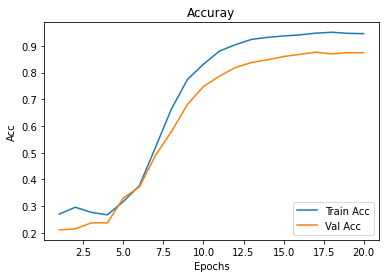

In [ ]:
fig = plt.figure()

plt.subplot(111)

plt.plot(np.arange(1,EPOCHS+1),train_acc)

plt.plot(np.arange(1,EPOCHS+1),val_acc)

plt.title("Accuray")

plt.xlabel("Epochs")

plt.ylabel("Acc")

plt.legend(["Train Acc","Val Acc"],loc = "lower right")

plt.savefig("/content/drive/MyDrive/nlp/model_data_Sentiment_yes_aug/model_data_Sentiment_yes_aug_Acc.png",dpi = 600)

plt.show()

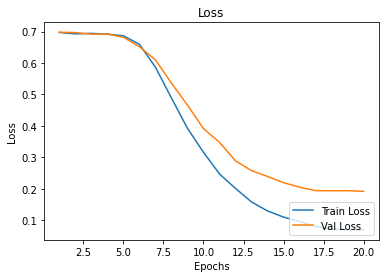

In [ ]:
fig = plt.figure()

plt.subplot(111)

plt.plot(np.arange(1,EPOCHS+1),train_loss)

plt.plot(np.arange(1,EPOCHS+1),val_loss)

plt.title("Loss")

plt.xlabel("Epochs")

plt.ylabel("Loss")

plt.legend(["Train Loss","Val Loss"],loc = "lower right")

plt.savefig("/content/drive/MyDrive/nlp/model_data_Sentiment_yes_aug/model_data_Sentiment_yes_aug_Loss.png",dpi = 600)

plt.show()

In [ ]:
model = torch.load('/content/drive/MyDrive/nlp/model_data_Sentiment_yes_aug/model_data_Sentiment_yes_aug.pt')

In [ ]:
evaluate(model, df_test)

Test Accuracy:  0.894


In [ ]:
my_text='''
پیش‌بینی آب و هوای امروز پنجشنبه ۷ فروردین وضعیت آب و هوا در ۲۴ ساعت گذشته، شرایط آب و هوای امروز و پیش‌بینی آب و هوای سه روز آینده'''
aug = naw.RandomWordAug()
aug.augment(my_text,n=3, num_thread=3)

['پیش \u200c هوای امروز ۷ فروردین وضعیت آب و هوا در ۲۴ ساعت گذشته ، و هوای پیش \u200c آب و هوای سه آینده',
 '\u200c آب هوای امروز پنجشنبه فروردین وضعیت آب و هوا در ۲۴ ساعت گذشته ، شرایط و هوای امروز و \u200c آب و هوای سه',
 'پیش \u200c بینی آب و هوای امروز پنجشنبه ۷ وضعیت آب هوا ۲۴ گذشته ، شرایط و هوای امروز و آب هوای سه روز']